## Import necessary libraries

In [2]:
import numpy as np
from PIL import Image
import torch
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt
import random
import math

# Task 1: Simple Image Operations

### 1. Load image

In [3]:
img = Image.open("./Capybara.jpg")

### 2. Print width, height, and number of channels and plot the image

height: 600
width: 800
nChannels: 3


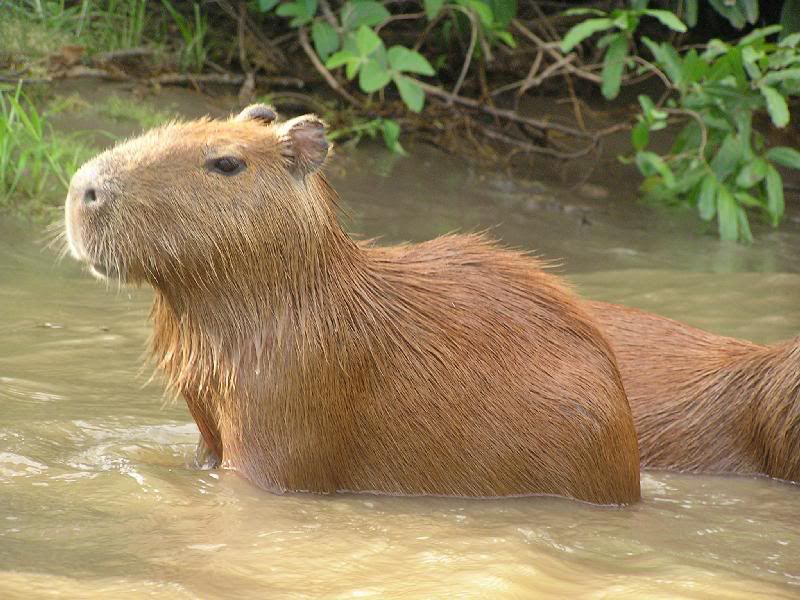

In [4]:
width = img.size[0]
height = img.size[1]
print("height:", height)
print("width:", width)
print("nChannels:", len(img.getbands()))

display(img)

### 3. Crop a random patch of size 256x256 from the image

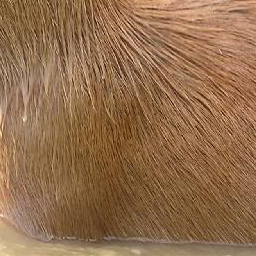

(256, 256)

In [21]:
# Select the top left corner of the to be cropped image patch randomly
top_x = random.randint(0,width-256)
top_y = random.randint(0,height-256)
box = (top_x,top_y,top_x+256,top_y+256)
cropped_img = img.crop(box)
display(cropped_img)
cropped_img.size

### 4. Convert the image patch to grayscale

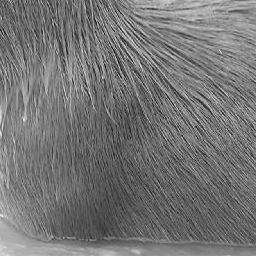

In [23]:
cropped_img = cropped_img.convert("L")
display(cropped_img)

### 5. Insert the grayscale patch back into the original image

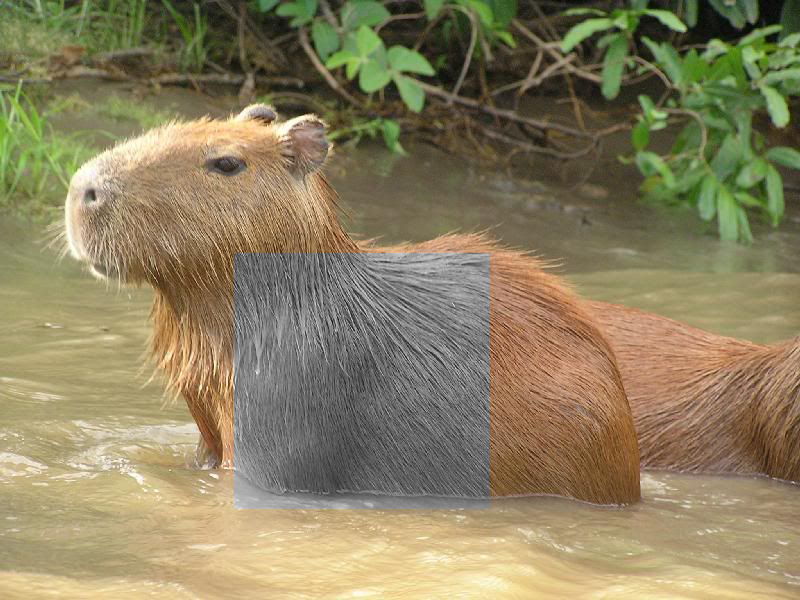

In [24]:
img.paste(cropped_img, box)
display(img)

### 6. Resize the image with the inserted gray patch 

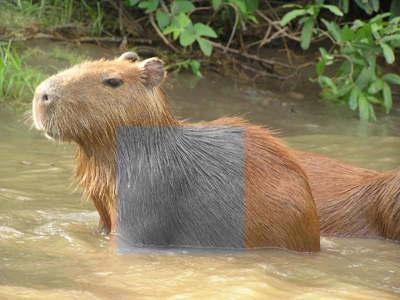

(400, 300)

In [25]:
size_ratio = min(400/width, 400/height)
new_width = int(width*size_ratio)
new_height = int(height*size_ratio)
small_img = img.resize((new_width,new_height))
display(small_img)
small_img.size


# Task 2: Convolution and Filters

### Utils
take care of the range of the value before plot the images

In [9]:
def display_img(x, norm=False):
    """
    Displays image
    """
    x = np.copy(x)
    # Normalize if necessary
    if norm:
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # Scale and convert to uint8 format for PIL plotting
    x *= 255
    x = x.astype(np.uint8)
    # Handle channel dimension
    if len(x.shape) == 2:
        x = x[:, :, np.newaxis]
    if x.shape[2] == 1:
        x = np.repeat(x, 3, axis=2)

    display(Image.fromarray(x))

def load_img(path, grayscale=False):
    """
    Loads image from given path, converts to float and normalize to [0,1] interval
    """
    img = Image.open(path)
    a = np.asarray(img, dtype=np.float32) / 255
    # Convert to grayscale if necessary
    if grayscale:
        a = np.mean(a, axis=2, keepdims=True)
    return a

### 1. Implement convolution operation

In [10]:
def conv2d(x, kernel):
    """
    Performs a 2D convolution operation with a single kernel.

    Args:
        x      (array): the input array of shape (H, W, 1).
        kernel (array): the kernel that is convolved over the input.

    Returns:
        out    (array): the output array.
    """
    out_y_dim = x.shape[0] - kernel.shape[0] + 1
    out_x_dim = x.shape[1] - kernel.shape[1] + 1
    print(out_y_dim, out_x_dim)
    out = np.empty([out_y_dim, out_x_dim])
    for y_dim in range(out_y_dim):
        for x_dim in range(out_x_dim):
            # calculate the sum of the product of the kernel with x
            out[y_dim,x_dim] = np.sum(x[y_dim:y_dim+kernel.shape[0], x_dim:x_dim+kernel.shape[1]] * kernel)
    return out     


### 2. Implement a Gaussian filter

Gaussian filter:


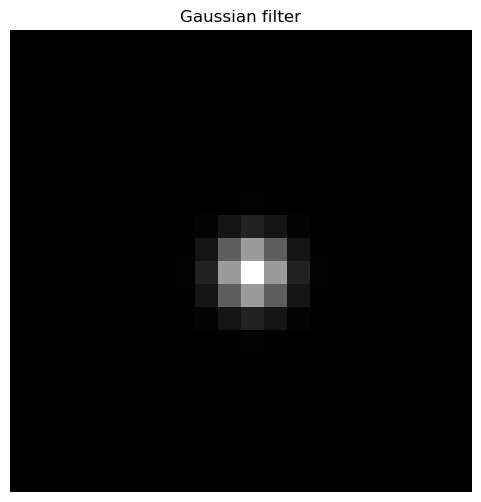

In [11]:
def gaussian_filter(size, mean=0, var=1):
    """
    Returns an isotropic Gaussian filter with.
    
    Args:
        size       (int): the size of the kernel.
        mean (float/int): the mean of the Gaussian.
        var  (float/int): the variance of the Gaussian.

    Returns:
        f        (array): the Gaussian filter of shape (size, size, 1).
    """
    # had to change this, so that the gaussian filter is centered
    if mean == 0:
        mean = size // 2
    filter = np.empty([size,size])
    for y in range(size):
        for x in range(size):
          # calculate the gaussian value for every filter position and also take mean into account
          filter[y, x] = (1 / (2 * math.pi * var)) * math.exp(-((x - mean) ** 2 + (y - mean) ** 2) / (2 * var))
    return filter / np.sum(filter)

f = gaussian_filter(size=20, mean=0, var=1)

# Plot the filter
print('Gaussian filter:')
plt.figure(figsize=(6, 6))
plt.imshow(f, cmap='gray')
plt.title('Gaussian filter')
plt.axis('off')
plt.show()
#display_img(f, norm=True)

### 3. Apply Gaussian filter to image

Original image:


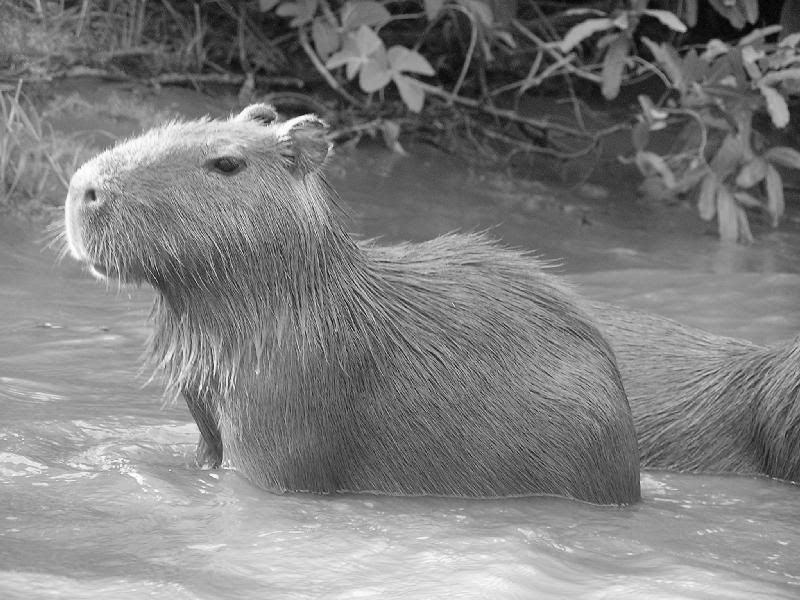

591 791
Gaussian filtered image:


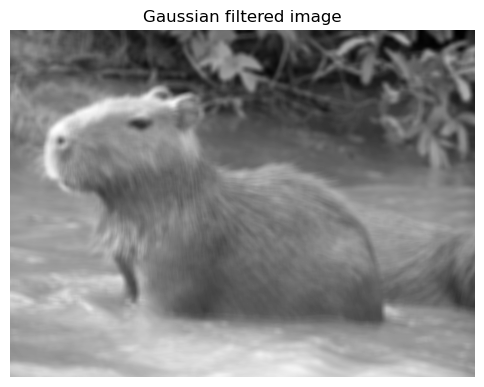

In [12]:
grayscale_img = Image.open("./Capybara.jpg").convert("L")
array = np.array(grayscale_img)
print('Original image:')
display_img(array, norm=True)

kernel = gaussian_filter(10, 10, 255)
norm_array = array / 255
array_filtered = conv2d(norm_array, kernel, )
# normalize values from 0-1 and then multiply by 255
gaussian_array_filtered = (array_filtered-np.min(array_filtered))/(np.max(array_filtered)-np.min(array_filtered))
gaussian_array_filtered = gaussian_array_filtered * 255

print('Gaussian filtered image:')
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_array_filtered, cmap='gray')
plt.title('Gaussian filtered image')
plt.axis('off')
plt.show()
#display_img(norm_array_filtered, norm=True)

### 4. Implement and apply Laplacian filter to image

Hint: If you only apply laplacian and use plt to plot without taking care of the value range, you would probably have a hard time to see something

Original image:


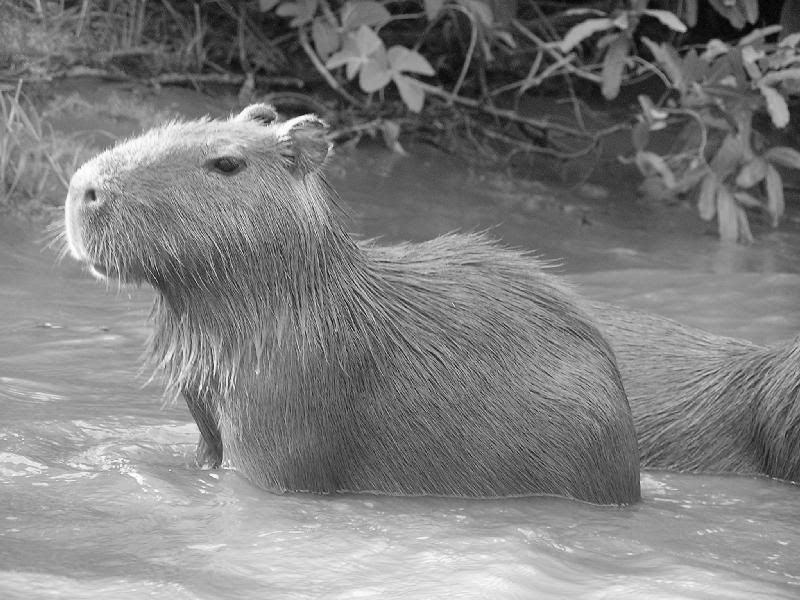

598 798
598 798


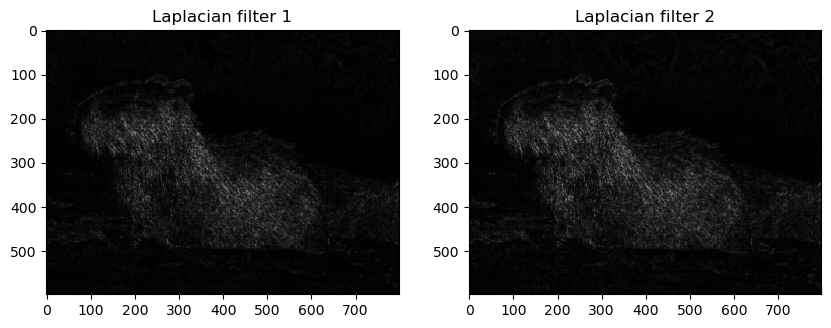

In [18]:
grayscale_img = Image.open("./Capybara.jpg").convert("L")
array = (np.array(grayscale_img.getdata()))
array = array.reshape(grayscale_img.size[::-1]) # size returns (width, height) but reshape expects (height, width)

print('Original image:')
display_img(array, norm=True)

# Define the laplacian filter according to my knowledge from machine learning lecture
laplacian_filter = np.array([[0, 1, 0], 
                             [1, -4, 1], 
                             [0, 1, 0]])
laplacion_filter_improved = np.array([[1, 4, 1],
                                     [4, -20, 4],
                                     [1, 4, 1]])

norm_array = array / 255

# Apply first laplacian filter
array_filtered = conv2d(norm_array, laplacian_filter)
array_filtered = np.abs(array_filtered)  # Take the absolute value to make edges more visible
norm_array_filtered = (array_filtered-np.min(array_filtered))/(np.max(array_filtered)-np.min(array_filtered))
norm_array_filtered = norm_array_filtered * 255

# Apply second laplacian filter
array_filtered2 = conv2d(norm_array, laplacion_filter_improved)
array_filtered2 = np.abs(array_filtered2)
norm_array_filtered2 = (array_filtered2-np.min(array_filtered2))/(np.max(array_filtered2)-np.min(array_filtered2))
norm_array_filtered2 = norm_array_filtered2 * 255

# Print both images next to each other for comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(norm_array_filtered, cmap='gray')
axs[0].set_title('Laplacian filter 1')

axs[1].imshow(norm_array_filtered2, cmap='gray')
axs[1].set_title('Laplacian filter 2')
plt.show()
#display_img(norm_array_filtered)

"""
The Laplace filter can detect edges by detecting strong brightness changes from dark->bright or bright->dark in close vicinity. 
In the context of images, the second derivative corresponds to the rate of change in the first derivative, 
which itself is the rate of change in pixel intensity.
Thus, when the first derivative reaches an optimum/minimum, then the second derivative will have a zero crossings.
These zero crossings are used to detect edges in images.
"""

### 5. Problems with handcrafted filters

The issue is, that you need to have a lot of knowledge to know which kind of filter to use for which kind of tasks. There are a lot of hyperparameters included that can be tuned, so there are a lot of different filter that can be designed. With the use of deep learning, a lot of filter solutions can be efficiently tested and the best filters can be found.

# Task 3: Introduction to PyTorch

### 1. Convert NumPy array to PyTorch tensor and vice versa

Original shape: (600, 800, 3)
Original shape: torch.Size([600, 800, 3])
Permuted shape: torch.Size([3, 600, 800])
2 times permuted shape: torch.Size([600, 800, 3])


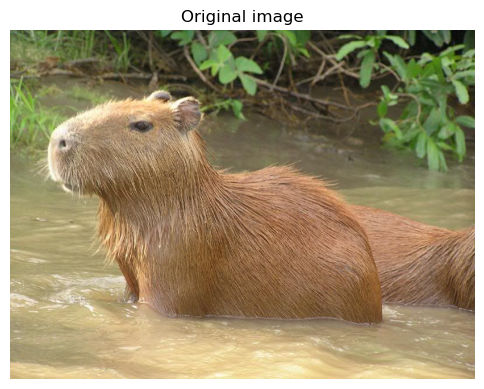

In [14]:
## Alternative
import torchvision.transforms.functional
img = Image.open("./Capybara.jpg")
tensor = torchvision.transforms.functional.pil_to_tensor(img)

# 1.1 Load the image [H, W, C]
img = np.array(Image.open("./Capybara.jpg"))
print("Original shape:", img.shape)

# 1.2 Convert numpy array into PyTorch tensor
tensor = torch.from_numpy(img)
print("Original shape:", tensor.shape)

# 1.3 swap axes to [C, H, W]
tensor = tensor.permute(2, 0, 1)
print("Permuted shape:", tensor.shape)

# 1.4 swap axes back to [H, W, C]
tensor = tensor.permute(1, 2, 0)
print("2 times permuted shape:", tensor.shape)

# 1.5 convert tensor to numpy array
array = tensor.numpy()

# 1.6 save the image
img = Image.fromarray(array.astype('uint8')) # Convert back to PIl
img.save('same_image.jpg')

# plot the image
plt.figure(figsize=(6, 6))
plt.imshow(array, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

### 2. Create a PyTorch convolution operator

In [26]:
# 2.1 create random numpy array
x = np.random.rand(5, 5, 1)
w = np.random.rand(2, 2, 1)

# 2.2 create nn.Conv2d object
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)
conv.weight # Access weight values

# 2.3 convert x and w to tensors []
x = torch.from_numpy(x)
w = torch.from_numpy(w)
w.shape
x = x.permute(2,0,1)
w = w.permute(2,0,1)

# 2.4 add dimension
x = x.unsqueeze(0)
w = w.unsqueeze(0)
# torch.Size([1, 1, 5, 5])
# first dim: kernel count
# second dim: channel count
# third dim: height
# fourth dim: width

# 2.5 replace weights of conv with w
conv.weight = torch.nn.Parameter(w) # Wraps w as a Parameter

# 2.6 apply convolution to image x
output = conv(x)
output.shape
print("torch conv2d function:")
print(output)

# 2.7 apply on own convolution function
own_x = x.permute(2,3,0,1)
own_x = own_x.numpy()
own_w = w.permute(2,3,0,1)
own_w = own_w.numpy()
output = conv2d(own_x, own_w)
print("my conv2d function:")
print(output)



torch conv2d function:
tensor([[[[0.6795, 0.1878, 0.1759, 0.2236],
          [0.4871, 0.3219, 0.3760, 0.9047],
          [0.8340, 0.4742, 0.5007, 0.8560],
          [0.4820, 0.5079, 0.4518, 0.4985]]]], dtype=torch.float64,
       grad_fn=<ConvolutionBackward0>)
4 4
my conv2d function:
[[0.67952451 0.18781591 0.17590536 0.2236237 ]
 [0.48708353 0.32189171 0.3759647  0.90469927]
 [0.83400234 0.47420466 0.50067142 0.8560461 ]
 [0.48202816 0.50787919 0.45175816 0.49847798]]


### 3. Apply Gaussian filter using nn.Conv2d

Original image:


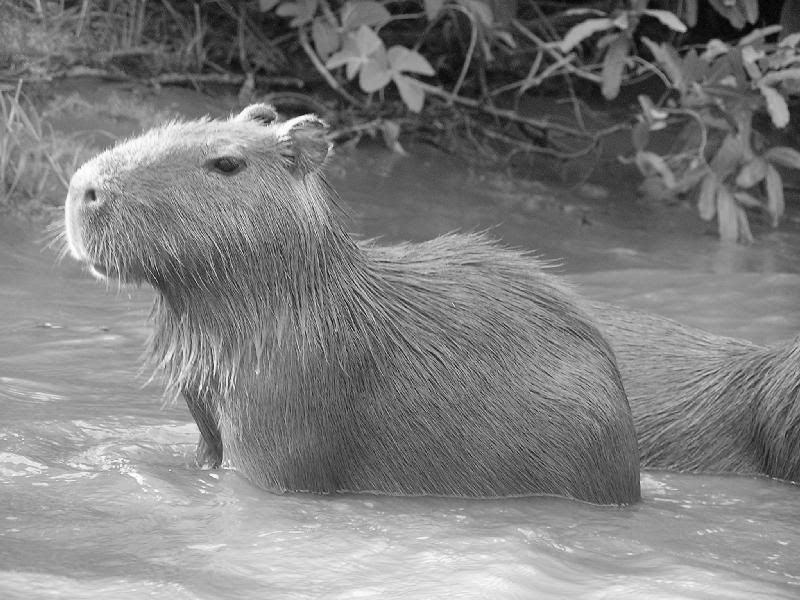

torch.Size([600, 800])
torch.Size([1, 1, 600, 800])
(20, 20)
torch.Size([1, 1, 10, 10])


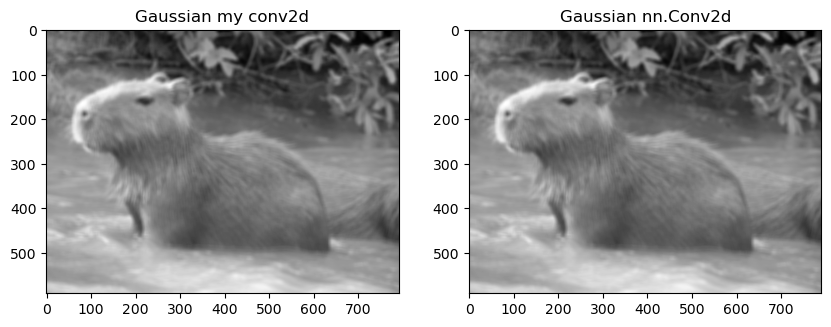

: 

In [27]:
x = np.array(Image.open("./Capybara.jpg").convert('L'))


print('Original image:')
display_img(x, norm=True)

x = torch.from_numpy(x).double() # Convert x to double to avoid errors
# Bring tensor to the form [1, 1, 600, 800]
print(x.shape)
x = x.unsqueeze(0)
x = x.unsqueeze(0)
print(x.shape)

# Create kernel as tensor
kernel = gaussian_filter(10, 10, 255)
kernel = torch.from_numpy(kernel)
print(f.shape)
kernel = kernel.unsqueeze(0)
kernel = kernel.unsqueeze(0)
print(kernel.shape)


conv = torch.nn.Conv2d(1, 1, 10, bias=False)
conv.weight = torch.nn.Parameter(kernel)

xx_filtered = conv(x)
xx_filtered = xx_filtered.detach().numpy() # Detach tensor from its computation graph
xx_filtered = xx_filtered[0, 0, :, :]

# Print both blurred images next to each other for comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(gaussian_array_filtered, cmap='gray')
axs[0].set_title('Gaussian my conv2d')

axs[1].imshow(xx_filtered, cmap='gray')
axs[1].set_title('Gaussian nn.Conv2d')
plt.show()

#display_img(xx_filtered, norm=True)
